In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')
sys.path.append('/usr/users/fsimone/tejaas')
import numpy as np
import scipy.stats as ss
import random
import os
import pandas as pd
from iotools.readRPKM import ReadRPKM
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA

def knn_correction(expr, K, f=1):
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1])))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    neighbor_list = list()

    neighbour_comp = np.zeros(expr.shape)
    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        neighbour_comp[i,:] = np.mean(expr[neighbors, :], axis = 0)

    return gx_knn, neighbour_comp

In [2]:
import operator
import json
from utils import utils
json_file = "../../gtex_v8_metadata.json"
tissue_file = "../../plots/tissues.txt"
tshorts, tfulls_plain = utils.read_tissues(tissue_file, plain=True)
_, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors  = dict()
tissue_names   = dict()
tissue_samples = dict()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull
for tshort, tfull in zip(tshorts, tfulls):
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

sorted_tissues = [x[0] for x in sorted(tissue_samples.items(), key=operator.itemgetter(1))]
select_tissues = ['ms', 'wb', 'sse', 'as', 'hlv', 'colt', 'bco', 'aa', 'ag' , 'ac', 'bca', 'ac', 'fib', 'bceh', 'bhi', 'tes', 'nt', 'thy']


In [3]:
def scale_covariates(df_cov):
    # scale covariates
    NAmask = pd.isna(df_cov)
    means = np.mean(df_cov.T)
    stds = np.std(df_cov.T)
    diff = (df_cov.T[~NAmask.T] - means) / stds
    return diff.T

def scale_covariates_nan(df_cov):
    new_df = pd.DataFrame([])
    for r in df_cov.index:
        NAmask = pd.isna(df_cov.loc[r])
        means = np.mean(df_cov.loc[r].T)
        stds = np.std(df_cov.loc[r].T)
        diff = pd.DataFrame((df_cov.loc[r][~NAmask] - means) / stds )
        new_df = pd.concat([new_df, diff.T],sort=False)
        # Nan values will be added as other sample names are introduced and gaps will be filled with Nans
    return new_df

In [4]:
## Subject Covariates from GTEx_v8 as in "The impact of rare variation on gene expression across tissues"
subj_file = "/cbscratch/franco/datasets/gtex_v8/phenotypes/phs000424.v8.pht002742.v8.p2.c1.GTEx_Subject_Phenotypes.GRU.txt"
subj_df = pd.read_csv(subj_file, comment="#", sep="\t", header=0)

cov_dict = dict()
cov_dict["TRDNISCH"]  = "Total Ischemic time for a donor"
cov_dict["TRISCHD"]   = "Ischemic Time (Minutes)"
cov_dict['DTHRFG']    = "Body Refrigerated"
cov_dict['MHSRC']     = 'Primaty History Source'
cov_dict["LBPRRVDRL"] = "PRR VDRL Serology"
cov_dict["LBHBCABM"]  = "HBcAb IgM Serology"
cov_dict["DTHATPSY"]  = "Autopsy performed By Coroner or ME"
cov_dict['AGE']       = "Age"
cov_dict['RACE']      = "Race"
cov_dict['MHABNWBC']  = "Abnormal WBC"
cov_dict["TRCRTMP"]   = "Core Body Temperature"
cov_dict["SEX"]       = "Sex"
cov_dict['DTHVNT']    = "Donor On A Ventilator Immediately Prior To Death"
cov_dict["DTHVNTD"]   = "Time Interval On Ventilator"
cov_dict["TRVNTSR"]   = "On ventilator less than 24 hours"
cov_dict["DTHVNT"]    = "Donor On A Ventilator Immediately Prior To Death"
cov_dict["LBEBVGAB"]  = "EBV IgG Ab"
cov_dict["LBEBVMAB"]  = "EBV IgM Ab"
cov_dict["LBCMVTAB"]  = "CMV Total Ab"
cov_dict['COHORT']    = "Cohort"
cov_dict["TRCHSTIND"] = "Time of Chest Incision (Minutes)"
cov_dict['DTHPLCE']   = "Place of Death"
cov_dict['DTHHRDY']   = "Hardy Scale"

# cov_dict["ETHNCTY"]   = "Ethnicity"
# cov_dict['DTHTYP']    = "Specific cause of death based on ICD-10 coding"
# cov_dict['DTHICD10']  = "ICD-10 Code for cause of death"
# cov_dict['DTHCLS']    = "Classification of death based on ICD-10 coding"
# cov_dict['DTHCAT']    = "Category of death based on ICD-10 coding"
# cov_dict['DTHCOD']    = "Immediate Cause Of Death"
# cov_dict['DTHFUCOD']  = "First Underlying Cause Of Death"
# cov_dict['DTHCERT']   = "Death Certificate Available"
# cov_dict['MHASCITES'] = "Ascites"
# cov_dict['DTHLUCOD']  = "Last Underlying Cause Of Death"
# cov_dict['TRISCH']    = "Ischemic Time"
# cov_dict['TRCRTMPL']  = "Core Body Temperature - Location of measurment"
# cov_dict["TRCHSTIN"]  = "Time of Chest Incision"
# cov_dict["DTHVNTDU"]  = "Time Interval On Ventilator Unit"

subj_covariates= list(cov_dict.keys()) 
select_columns = ["SUBJID"] + subj_covariates
SUBJ_DF = subj_df[select_columns]

In [5]:
## Sample Covariates 
sample_file = "/cbscratch/franco/datasets/gtex_v8/phenotypes/phs000424.v8.pht002743.v8.p2.c1.GTEx_Sample_Attributes.GRU.txt"
sample_df = pd.read_csv(sample_file, comment="#", sep="\t", header=0)

sample_cov_dict = dict()
sample_cov_dict["SMTRSCPT"] = "Transcripts Detected" #: Total number of transcripts with at least 5 exon mapping reads"
sample_cov_dict["SMGNSDTC"] = "Genes detected"
sample_cov_dict["SMSPLTRD"] = "Split Reads"
sample_cov_dict["SMCENTER"] = "Code for BSS collection site"
sample_cov_dict["SMATSSCR"] = "Autolysis Score"
sample_cov_dict["SME2PCTS"] = "End 2 % Sense" # : Percentage of intragenic End 2 reads that were sequenced in the sense direction"
sample_cov_dict["SME1SNSE"] = "End 1 Sense" # : Number of End 1 reads that were sequenced in the sense direction"
sample_cov_dict["SME2SNSE"] = "End 2 Sense" # : Number of End 2 reads that were sequenced in the sense direction"
sample_cov_dict["SME2ANTI"] = "End 2 Antisense" # : Number of reads that were sequenced in the antisense direction"
sample_cov_dict["SME1ANTI"] = "End 1 Antisense" # : Number of End 1 reads that were sequenced in the antisense direction"
sample_cov_dict["SME1MPRT"]  = "End 1 Mapping Rate" # : the number of End 1 mapped reads divided by the total number of End 1 reads"
sample_cov_dict["SME2MPRT"]  = "End 2 Mapping Rate" # : the number of End 2 mapped reads divided by the total number of End 1 reads"
sample_cov_dict["SME1MMRT"]  = "End 1 Mismatch Rate" # : The number of End 1 bases not matching the reference divided by the total number of End 1 bases."
sample_cov_dict["SME2MMRT"]  = "End 2 Mismatch Rate" #  The number of End 2 bases not matching the reference divided by the total number of End 2 bases."
sample_cov_dict["SMMPPDUN"]  = "Mapped Unique" # : Number of reads that were aligned and did not have duplicate flags"
sample_cov_dict["SMMPPD"]    = "Mapped" # : Total number of reads aligned/mapped"
sample_cov_dict["SMMPPDPR"]  = "Mapped Pairs" # :Total number of pairs for which both ends map"
sample_cov_dict["SMRDTTL"]   = "Total reads" #  (filtered to exclude reads with vendor fail or alternative alignment flags)"
sample_cov_dict["SMMFLGTH"]  = "Fragment Length Mean"
sample_cov_dict["SMSFLGTH"]  = "Fragment Length StdDev" # : The fragment length is the distance between the start of an upstream read and the end of the downstream pair mate"
sample_cov_dict["SMALTALG"]  = "Alternative Aligments" # : duplicate read entries providing alternative coordinates"
sample_cov_dict["SMNTERRT"]  = "Intergenic Rate" # : The fraction of reads that map to the genomic space between genes"
sample_cov_dict["SMNTRART"]  = "Intragenic Rate" # : The fraction of reads that map within genes (within introns or exons)"
sample_cov_dict["SMRRNART"]  = "RRNA Rate" # : Ratio of all reads aligned to rRNA regions to total reads"
sample_cov_dict["SMRRNANM"]  = "RRNA: Number of all reads" #  (duplicate and non-duplicate) aligning to ribosomal RNA regions"
sample_cov_dict["SMTSISCH"]  = "Total Ischemic time for a sample"
sample_cov_dict["SMRIN"]     = "RIN Number"
sample_cov_dict["SMNTRNRT"]  = "Intronic Rate" # : The fraction of reads that map within introns"
sample_cov_dict["SMEXNCRT"]  = "Exonic Rate" # : The fraction of reads that map within exons"
sample_cov_dict["SMEXPEFF"]  = "Expression Profiling Efficiency" # : Ratio of exon reads to total reads"
sample_cov_dict["SMGEBTCHD"] = "Date of genotype or expression batch"
sample_cov_dict["SMNABTCHT"] = "Type of nucleic acid isolation batch"
sample_cov_dict["SMGEBTCH"]  = "Genotype or Expression Batch ID"
sample_cov_dict["SMNABTCHD"] = "Date of nucleic acid isolation batch"
sample_cov_dict["SMNABTCH"]  = "Nucleic Acid Isolation Batch ID"

sample_cov_dict["SME1PCTS"] = "End 1 % Sense" # : Percentage of intragenic End 1 reads that were sequenced in the sense direction"
sample_cov_dict["SMMAPRT"]  = "Mapping Rate" # : Ratio of total mapped reads to total reads"
sample_cov_dict["SMUNMPRT"] = "Unique Rate of Mapped" # : Unique reads divided by all mapped reads."
sample_cov_dict["SMMPUNRT"] = "Mapped Unique Rate of Total" # : Ratio of mapping of reads that were aligned and were not duplicates to total reads"
sample_cov_dict["SMESTLBS"] = "Estimated library size" # : Number of expected fragments based on the total reads and duplication rate assuming a Poisson distribution."

sample_cov_dict["SMTSD"]    = "Tissue Type"

sample_covariates= list(sample_cov_dict.keys()) 
select_columns = ["SAMPID"] + sample_covariates
# Make sure to select TruSeq RNA-seq experiments!! in SMGEBTCHT
# Remove FLAGGED samples! duh!
SAMPLE_DF = sample_df[sample_df["SMGEBTCHT"].str.match("TruSeq") & ~sample_df["SMTORMVE"].str.match("FLAGGED").fillna(False) ][select_columns]

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Factorize categories in both covariate sets
* Dates are just converted to consecutive number (but without any date ordering)

In [6]:
# Binarize any thing with more than 4 categories
# Also, take car of covariates encoded in numbers, delete those '98' or '99' that just mean 'unknown'
for c,t in zip(subj_covariates, SUBJ_DF[subj_covariates].dtypes):
    if t == "object":
        # print(c, set(SUBJ_DF[c]),t)
        values, categories = SUBJ_DF[c].factorize()
        if len(categories) > 1 and len(categories) <= 4:
            # Split each category into a new binary columns
            for x in range(len(categories)):
                new_cat_name = c+"_{:d}".format(x)
                cov_dict[new_cat_name] = f"{cov_dict[c]} - {categories[x]}"
                new_values = np.zeros(values.shape)
                new_values[values == x ] = 1
                new_values[values == -1] = np.nan
                SUBJ_DF[new_cat_name] = new_values    
            SUBJ_DF.drop(c, axis=1, inplace=True)
        else:
            # Already binarizable, easy!
            SUBJ_DF.loc[:,c] = values
            SUBJ_DF[c].replace({-1:np.nan}, inplace=True)
    elif c in ["RACE","DTHRFG","LBPRRVDRL","LBHBCABM","DTHVNT","LBEBVGAB","LBEBVMAB","LBCMVTAB"]:
        SUBJ_DF.loc[ SUBJ_DF[c] > 4, c ] = np.nan

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [7]:
for c,t in zip(sample_covariates, SAMPLE_DF[sample_covariates].dtypes):
    if t == "object":
        # print(c, set(SAMPLE_DF[c]),t)
        if c == "SMTSD": # Don't do for tissue type
            continue
        values, categories = SAMPLE_DF[c].factorize()
        # if it has more than 4 categories, just leave it as is and assign numbers
        if len(categories) > 1 and len(categories) <= 4:
            # Split each category into a new binary columns
            for x in range(len(categories)):
                new_cat_name = c+"_{:d}".format(x)
                sample_cov_dict[new_cat_name] = f"{sample_cov_dict[c]} - {categories[x]}"
                new_values = np.zeros(values.shape)
                new_values[values == x ] = 1
                new_values[values == -1] = np.nan
                SAMPLE_DF[new_cat_name] = new_values
            SAMPLE_DF.drop(c, axis=1, inplace=True)
        else:
            # Already binarizable, easy!
            SAMPLE_DF.loc[:,c] = values
            SAMPLE_DF[c].replace({-1:np.nan}, inplace=True)

In [8]:
knn_cov_r2 = pd.DataFrame([])
multi_r2   = list()
multi_r2_c = list()
R2_CUTOFF = 0.05

multi_r2_lasso = list()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull

for tissue in tshorts:
    if tissue not in select_tissues:
        continue
    print(tissue)
    gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_noage23/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue)
    rpkm = ReadRPKM(gx_file, "gtex")
    expression = rpkm.expression
    expr_donors = rpkm.donor_ids
    gene_names = rpkm.gene_names

    gx_corr, nb_comp = knn_correction(expression.T, 30)
    nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)

    # Covariates have size Covariates (rows) x Nsamples (columns)
    
    # PUBLIC Covariates
    cov_file = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_noage23/gtex_v8/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
    df_cov_pub = pd.read_csv(cov_file, sep="\t", header=0, index_col=0)
    df_cov_pub.drop(["sex", "AGE", "PMI"], inplace=True)
    
    # SUBJECT covariates
    df_cov = SUBJ_DF.T.copy(deep=True)
    df_cov.columns = df_cov.loc["SUBJID"]
    df_cov.drop(["SUBJID"], inplace=True)
    
    # SAMPLE covariates
    TISSUE_SAMPLE_DF = SAMPLE_DF[ SAMPLE_DF["SMTSD"] == tissue_names[tissue] ].T.copy(deep=True)
    new_columns = ["-".join(i.split("-")[:2]) for i in TISSUE_SAMPLE_DF.loc["SAMPID"].values]
    TISSUE_SAMPLE_DF.columns = new_columns
    TISSUE_SAMPLE_DF.drop("SAMPID", inplace=True)

    ALL_COVS = pd.concat([df_cov_pub, df_cov, TISSUE_SAMPLE_DF], join='inner')
    TISSUE_COVS = ALL_COVS.loc[~(ALL_COVS.nunique(axis=1) == 1),:]
    
    sort_cov_df = scale_covariates_nan(TISSUE_COVS[nb_df.columns])
    
    # Multiple Linear regression of each covariate against KNN component of expression
    r2_list = list()
    covname_list   = list()
    K = 30
    
    # Iterate through covariates one by one
    for i in range(sort_cov_df.shape[0]):
        reg = linear_model.LinearRegression()
        nan_mask = pd.isna(sort_cov_df.iloc[i,:].values)
        observations_left = sort_cov_df.shape[1] - np.sum(nan_mask)
        if observations_left > 50:
            X = sort_cov_df.iloc[i,:].values[~nan_mask][:,np.newaxis]
            Y = nb_df.iloc[:,~nan_mask].T 

            reg.fit(X, Y)
            r2 = reg.score(X, Y)
            r2_list.append(r2)
            covname_list.append(sort_cov_df.index[i])
            print(sort_cov_df.index[i], r2)
        else:
            print(sort_cov_df.index[i], "Not enough obs ({:d})".format(observations_left))
    
    tissue_r2_df = pd.DataFrame(np.array(r2_list), index=covname_list, columns = [tissue])
    knn_cov_r2 = pd.concat([knn_cov_r2, tissue_r2_df], axis=1, sort=True)
    
    gx_corr, nb_comp = knn_correction(expression.T, K)
    nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
    reg = linear_model.LinearRegression()
    X = sort_cov_df.loc[covname_list].T ## (12, 581,)
    Y = nb_df.T 
    reg.fit(X.fillna(0), Y)
    r2 = reg.score(X.fillna(0), Y)
    multi_r2.append((tissue, r2))
    print("R^2 : {:g}".format(r2))
    
    covname_list_c = knn_cov_r2[ knn_cov_r2[tissue] > R2_CUTOFF ].index
    X = sort_cov_df.loc[covname_list_c].T 
    Y = nb_df.T 
    reg.fit(X.fillna(0), Y)
    r2 = reg.score(X.fillna(0), Y)
    multi_r2_c.append((tissue, r2))
    print("R^2 w CUTOFF: {:g}".format(r2))

as
PC1 0.2742298027040134
PC2 0.0025603278142619142
PC3 0.0012485631561980112
PC4 0.0024077926677780817
PC5 0.0033871718657323725
pcr 0.001498854372311051
platform 0.002806890236232645
TRDNISCH 0.07294856156221834
TRISCHD 0.07469910653358183
DTHRFG 0.06696700351437093
LBHBCABM 0.0037986574043600055
DTHATPSY 0.02390866834513347
AGE 0.025801222691320777
RACE 0.17078353660641504
MHABNWBC 0.0006343799113085637
TRCRTMP 0.01708793616586735
SEX 0.005757518165565323
DTHVNT 0.0796073170113349
DTHVNTD 0.008081170601828832
LBEBVGAB 0.006822255546346312
LBEBVMAB 0.001966220544543803
LBCMVTAB 0.024454822711156027
TRCHSTIND 0.08635129865982444
DTHPLCE 0.03548118826713709
DTHHRDY 0.060572875088328516
MHSRC_0 0.0134808284363035
MHSRC_1 0.013480828436303499
COHORT_0 0.08151176324901045
COHORT_1 0.08260397052034155
COHORT_2 0.038971628940670966
SMTRSCPT 0.035390720189310186
SMGNSDTC 0.03530918606565422
SMSPLTRD 0.002563544677236546
SMCENTER 0.021667946369811987
SMATSSCR 0.005390274032731363
SME2PCTS 0.0

LBHBCABM 0.00947479888410321
DTHATPSY 0.0040083390298717315
AGE 0.01844471010973128
RACE 0.15069027433560772
MHABNWBC 0.002784256022519256
TRCRTMP 0.01802083366446536
SEX 0.0029170411925634925
DTHVNT 0.003089495748430092
DTHVNTD Not enough obs (14)
LBEBVGAB Not enough obs (0)
LBEBVMAB Not enough obs (0)
TRCHSTIND 0.004067686587235722
DTHPLCE 0.007611682422987965
DTHHRDY 0.039660466475971566
MHSRC_0 0.004446435493585796
MHSRC_1 0.004446435493585796
SMTRSCPT 0.03675885516428733
SMGNSDTC 0.03680725766306476
SMSPLTRD 0.03986880166136817
SMCENTER 0.013395484769137385
SMATSSCR Not enough obs (0)
SME2PCTS 0.03815202184862598
SME1SNSE 0.00928249004856535
SME2SNSE 0.010062313900638779
SME2ANTI 0.008046436305006666
SME1ANTI 0.008541516749803893
SME1MPRT 0.006636451061784503
SME2MPRT 0.006713895631931974
SME1MMRT 0.021943944605426403
SME2MMRT 0.0036287029733949676
SMMPPDUN 0.008792317418022735
SMMPPD 0.008792317418022735
SMMPPDPR 0.008882353396546971
SMRDTTL 0.007462793509175755
SMMFLGTH 0.027680

SME1SNSE 0.06318144993532974
SME2SNSE 0.06414402127087158
SME2ANTI 0.06402274224611607
SME1ANTI 0.06406020131778734
SME1MPRT 0.004080131454440887
SME2MPRT 0.00942960601012688
SME1MMRT 0.010906959013279434
SME2MMRT 0.005939314681488432
SMMPPDUN 0.06035139580329498
SMMPPD 0.06035139580329498
SMMPPDPR 0.0606635914838859
SMRDTTL 0.05965319826946246
SMMFLGTH 0.05701791789351468
SMSFLGTH 0.05425926292259859
SMALTALG 0.003637689504548209
SMNTERRT 0.0046062283559237666
SMNTRART 0.004655789158767987
SMRRNART 0.1154669904266721
SMRRNANM 0.033413627354323745
SMTSISCH 0.009242053254891724
SMRIN 0.013538572607985348
SMNTRNRT 0.0706978816701282
SMEXNCRT 0.03719165425188105
SMEXPEFF 0.03784276002703531
SMGEBTCHD 0.03926230490472406
SMGEBTCH 0.04834924475046279
SMNABTCHD 0.06345810883868175
SMNABTCH 0.05490730848324802
SME1PCTS 0.006049636101225865
SMMAPRT 0.0060601412141599925
SMMPUNRT 0.0060601412141599925
R^2 : 0.628337
R^2 w CUTOFF: 0.526109
colt
PC1 0.049379969926085315
PC2 0.0018436687997964581


SME1MMRT 0.004700437006188542
SME2MMRT 0.0017412910002127502
SMMPPDUN 0.0008063443208005734
SMMPPD 0.0008063443208005734
SMMPPDPR 0.0008087873312758137
SMRDTTL 0.0018829145508731172
SMMFLGTH 0.0061354485420297145
SMSFLGTH 0.005082438727924443
SMALTALG 0.0008588587057222156
SMNTERRT 0.0625022075555728
SMNTRART 0.06258050128280263
SMRRNART 0.005923288501875661
SMRRNANM 0.0053016847326384856
SMTSISCH 0.07286281418358123
SMRIN 0.0025398586994995337
SMNTRNRT 0.08981807442608122
SMEXNCRT 0.09220501969242759
SMEXPEFF 0.011524084728197017
SMGEBTCHD 0.0070993377412235485
SMGEBTCH 0.008425623375645747
SMNABTCHD 0.005790060092817423
SMNABTCH 0.007469755665142185
SME1PCTS 0.0016091451039954828
SMMAPRT 0.002957782193579312
SMMPUNRT 0.002957782193579312
SMNABTCHT_0 0.006320442708760532
SMNABTCHT_3 0.006320442708760532
R^2 : 0.574359
R^2 w CUTOFF: 0.493081
sse
PC1 0.15366157828438273
PC2 0.0010911078559087412
PC3 0.0041800650968768565
PC4 0.0009055553252357604
PC5 0.0009619599443310582
pcr 0.00222319

SMRDTTL 0.014438890334797273
SMMFLGTH 0.01368212093231669
SMSFLGTH 0.0052342698084458395
SMALTALG 0.0022616517964044493
SMNTERRT 0.24527950417985814
SMNTRART 0.24596076700322758
SMRRNART 0.14896501400531337
SMRRNANM 0.11076018726474574
SMTSISCH 0.044004237785285324
SMRIN 0.008281992874406553
SMNTRNRT 0.03488089448826426
SMEXNCRT 0.032012386416842904
SMEXPEFF 0.02120753455370124
SMGEBTCHD 0.001769980552762518
SMGEBTCH 0.001488741486194715
SMNABTCHD 0.0015486997887314813
SMNABTCH 0.002065325974563683
SME1PCTS 0.004481555630306616
SMMAPRT 0.011793213898259314
SMMPUNRT 0.011793213898259314
SMNABTCHT_0 0.0024997561358923942
SMNABTCHT_3 0.0024997561358923942
R^2 : 0.68147
R^2 w CUTOFF: 0.451763


In [9]:
# contains r2 against each covariate individually
if not os.path.exists("results"): 
    os.makedirs("results")
    
knn_cov_r2.to_csv("results/multi_r2_ALL.txt", header=True, index=True, sep="\t")

# r2 of multiple linear regression (all covariates)
with open("results/knn_k30_r2_ALL.txt", 'w') as outstream:
    for t,r in multi_r2:
        outstream.write("{:s}\t{:g}\n".format(t, r))
        
# r2 of multiple linear regression (covariates r2 > 0.05)
with open("results/knn_k30_r2_cutoff{:g}.txt".format(R2_CUTOFF), 'w') as outstream:
    for t,r in multi_r2_c:
        outstream.write("{:s}\t{:g}\n".format(t, r))

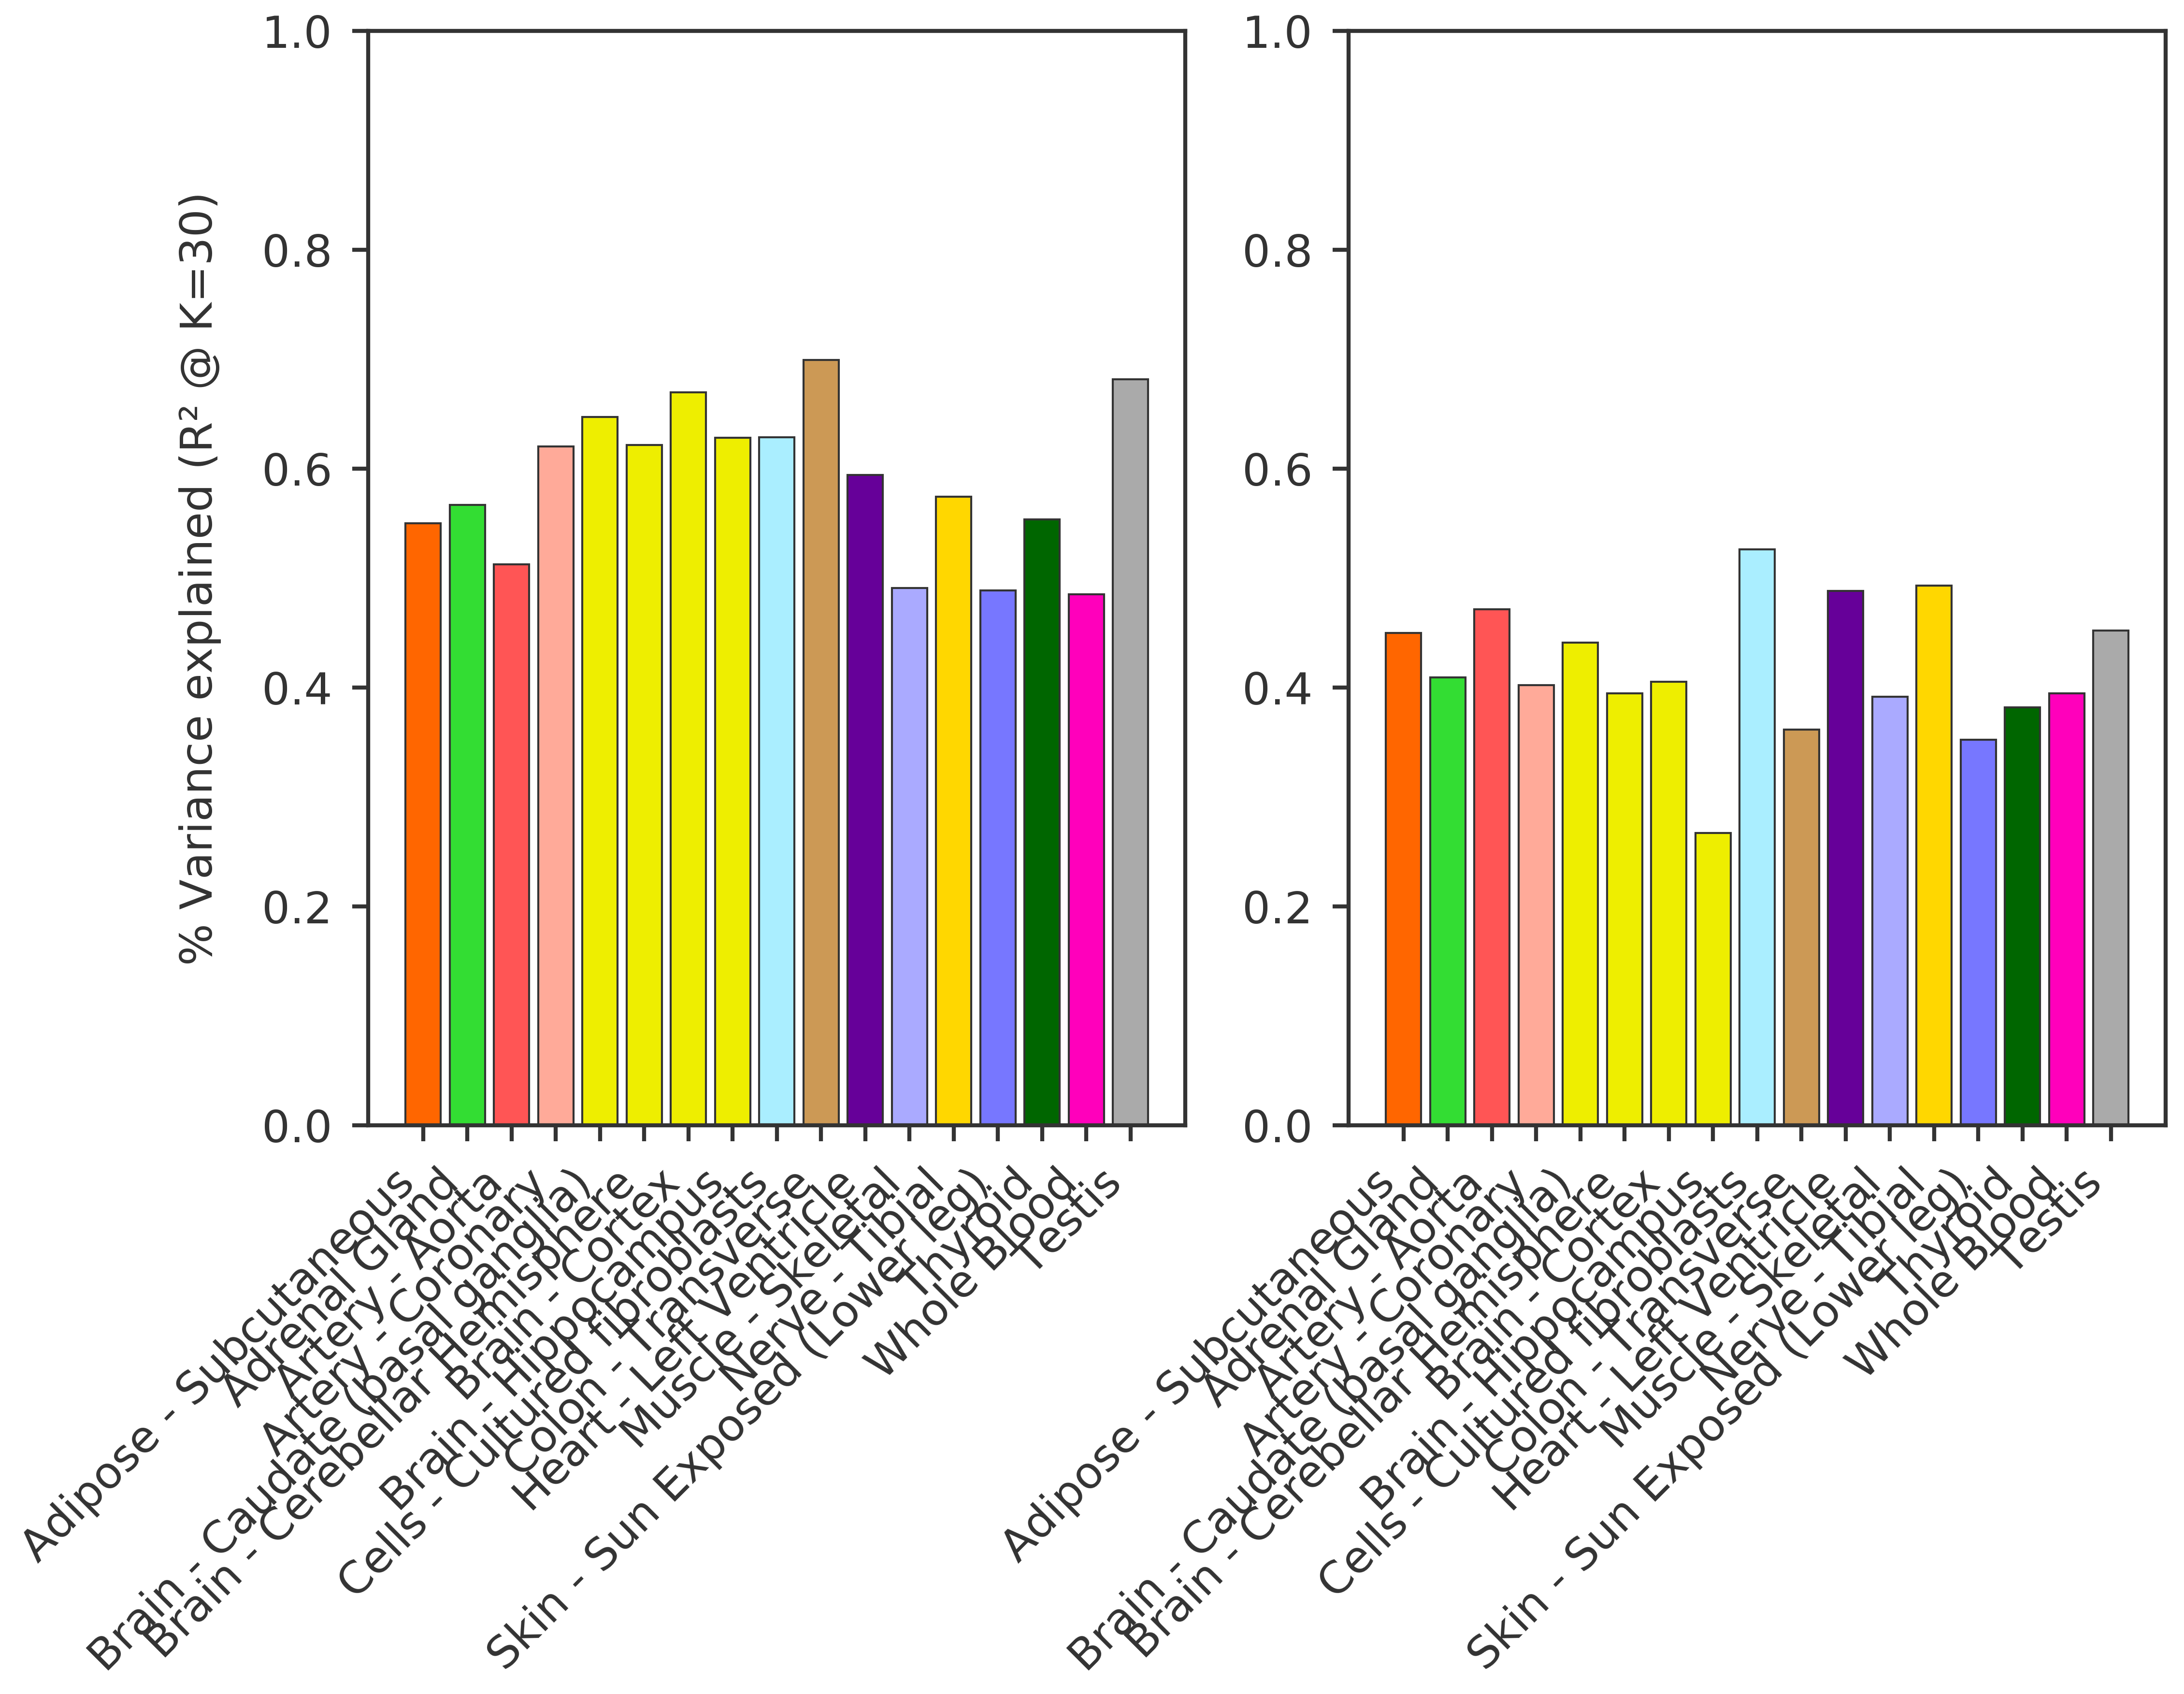

In [10]:
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

fig = plt.figure(figsize=(16,10))
ax1  = fig.add_subplot(121)
ax2  = fig.add_subplot(122)
x = [x[0] for x in multi_r2]
y = [x[1] for x in multi_r2]
ax1.bar(x, y, color=[tissue_colors[i] for i in x])
ax1.set_xticklabels([tissue_names[i] for i in x], rotation=45, ha="right")
ax1.set_ylabel("% Variance explained (R² @ K=30)")
ax1.set_ylim(0,1)

x = [x[0] for x in multi_r2_c]
y = [x[1] for x in multi_r2_c]
ax2.bar(x, y, color=[tissue_colors[i] for i in x])
ax2.set_xticklabels([tissue_names[i] for i in x], rotation=45, ha="right")
# ax2.set_ylabel("% Variance explained (R² @ K=30)")
ax2.set_ylim(0,1)
plt.show()

In [11]:
covname_list

['PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'pcr',
 'platform',
 'TRDNISCH',
 'TRISCHD',
 'DTHRFG',
 'LBHBCABM',
 'DTHATPSY',
 'AGE',
 'RACE',
 'MHABNWBC',
 'TRCRTMP',
 'DTHVNT',
 'DTHVNTD',
 'LBEBVGAB',
 'LBEBVMAB',
 'LBCMVTAB',
 'TRCHSTIND',
 'DTHPLCE',
 'DTHHRDY',
 'MHSRC_0',
 'MHSRC_1',
 'COHORT_0',
 'COHORT_1',
 'SMTRSCPT',
 'SMGNSDTC',
 'SMSPLTRD',
 'SMCENTER',
 'SMATSSCR',
 'SME2PCTS',
 'SME1SNSE',
 'SME2SNSE',
 'SME2ANTI',
 'SME1ANTI',
 'SME1MPRT',
 'SME2MPRT',
 'SME1MMRT',
 'SME2MMRT',
 'SMMPPDUN',
 'SMMPPD',
 'SMMPPDPR',
 'SMRDTTL',
 'SMMFLGTH',
 'SMSFLGTH',
 'SMALTALG',
 'SMNTERRT',
 'SMNTRART',
 'SMRRNART',
 'SMRRNANM',
 'SMTSISCH',
 'SMRIN',
 'SMNTRNRT',
 'SMEXNCRT',
 'SMEXPEFF',
 'SMGEBTCHD',
 'SMGEBTCH',
 'SMNABTCHD',
 'SMNABTCH',
 'SME1PCTS',
 'SMMAPRT',
 'SMMPUNRT',
 'SMNABTCHT_0',
 'SMNABTCHT_3']